In [103]:
from trainer import Trainer 
import torch
#import validate
from transformer.utils import subsequent_mask
import matplotlib.pyplot as plt
import seaborn
from dataset.iwslt import IWSLTDatasetBuilder
from transformer.model import Transformer
from logging import getLogger 

### Load model 

In [104]:
params_model = {
    'd_model': 512,
    'N': 6,
    'dropout': 0.1,
    'src_vocab_size': 46149,
    'tgt_vocab_size': 35385,

    'attention': {
        'n_head': 8,
        'd_k': 64,
        'd_v': 64,
        'dropout': 0.1},

    'feed-forward': {
        'd_ff': 2048,
        'dropout': 0.1
    }
}

In [3]:
logger = getLogger(name = 'loging_epoch24')
model = Transformer.load_model_from_file(
    '/Users/alexisdurocher/Docs/YouTheaSea/P19/cours/CS7243_DL/project/deep-learning-project/experiments/IWSLT/model_epoch_24.pt'
                                         
                                         , logger, params_model)

### Load vocabularies

In [4]:
max_length = 40
params = {
    "training": {
        "epochs": 1,
        "train_batch_size": 1024,
        "valid_batch_size": 1024,
        "smoothing": 0.1,
        "save_intermediate": False,
        "multi_gpu": False,
        "load_trained_model": False,
        "trained_model_checkpoint": "",
    },
    "optim": {
        "lr": 0.0,
        "betas": (0.9, 0.98),
        "eps": 1e-9,
        "factor": 1,
        "warmup": 2000,
        "step": 0,
    },
    "settings": {
        "pytorch_seed": 0,
        "numpy_seed": 0,
        "random_seed": 0,
        "save_intermediate": False,
        "multi_gpu": True,
    },
    "dataset": {
        "max_seq_length": max_length,  # ~ 90% of the training set
        "min_freq": 2,
        "start_token": "<s>",
        "eos_token": "</s>",
        "pad_token": "<blank>",
    },
    "model": {
        "d_model": 512,
        "N": 6,
        "dropout": 0.1,
        "attention": {"n_head": 8, "d_k": 64, "d_v": 64, "dropout": 0.1},
        "feed-forward": {"d_ff": 2048, "dropout": 0.1},
    },
}
trainer_ = Trainer(params)

[2019-04-30 20:44:43] - INFO - Trainer >>> Folder experiments/IWSLT/20190430_204443/ created.
[2019-04-30 20:44:43] - INFO - Trainer >>> Log File experiments/IWSLT/20190430_204443/training.log created.
[2019-04-30 20:44:43] - INFO - Trainer >>> Model folder experiments/IWSLT/20190430_204443/models/ created.
[2019-04-30 20:44:43] - INFO - Trainer >>> torch seed was set to 0
[2019-04-30 20:44:43] - INFO - Trainer >>> numpy seed was set to 0
[2019-04-30 20:44:43] - INFO - Trainer >>> random seed was set to 0
[2019-04-30 20:44:43] - INFO - Trainer >>> Configuration saved to experiments/IWSLT/20190430_204443/params.json.
[2019-04-30 20:44:43] - INFO - root >>> Failed to import cuda module: No module named 'caffe2.python.caffe2_pybind11_state_gpu'
[2019-04-30 20:44:43] - INFO - root >>> Failed to import AMD hip module: No module named 'caffe2.python.caffe2_pybind11_state_hip'
[2019-04-30 20:44:43] - WARNING - root >>> This caffe2 python run does not have GPU support. Will run in CPU only mod

In [7]:
_, src_vocab, trg_vocab = trainer_.model, trainer_.src_vocab, trainer_.trg_vocab

#### Chose a random sample from training, validation or testing dataset

In [8]:
### training
word = 0
batch = next(IWSLTDatasetBuilder.masked(IWSLTDatasetBuilder.transposed(
                        trainer_.training_dataset_iterator)))
src_, trg_ = batch.src[0], batch.trg[0]

In [9]:
### validation 
word = 0
batch = next(IWSLTDatasetBuilder.masked(IWSLTDatasetBuilder.transposed(
                        trainer_.validation_dataset_iterator)))
src_, trg_ = batch.src[0], batch.trg[0]

In [105]:
### test 
word = 0
batch = next(IWSLTDatasetBuilder.masked(IWSLTDatasetBuilder.transposed(
                        trainer_.test_dataset_iterator)))
src_, trg_ = batch.src[0], batch.trg[0]

In [106]:
source = [src_vocab.itos[token] for token in src_] # french version
target = [trg_vocab.itos[token] for token in trg_] # english version
print(f'Source French sentence:\n {source}')
print(f'\nTarget English sentence:\n{target}')

Source French sentence:
 ['Si', "quelqu'un", 'marche', 'derrière', ',', 'ça', 'veut', 'dire', '«', 'suivre', '»', '.', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>']

Target English sentence:
['<s>', 'If', 'someone', 'walks', 'behind', ',', 'that', 'is', '``', 'to', 'follow', '.', "''", '</s>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>']


#### Greedy Decoder

In [108]:
model.eval()
start_symbol ="<s>"
stop_symbol="</s>"
blank_symbol = "<blank>"

sent = source
src = torch.LongTensor([[src_vocab.stoi[w] for w in sent]])
src_mask = (src != src_vocab.stoi[blank_symbol]).unsqueeze(-2)

In [109]:
# 1. Embedding src
embedded = model.src_embeddings(src.type(torch.LongTensor))
embedded.shape

torch.Size([1, 39, 512])

In [110]:
# 2. Encode embedded inputs
memory = model.encoder(src=embedded, mask=src_mask)
memory.shape

torch.Size([1, 39, 512])

In [111]:
# 3. Create initial input for decoder
decoder_in = torch.ones(src.shape[0], 1).type(torch.FloatTensor) * trg_vocab.stoi[start_symbol]
decoder_in

tensor([[2.]])

In [112]:
sent_length = len(src_mask[src_mask>0])
sent_length

12

In [113]:
logits = []
## decode each word one by one considering previous output
for i in range(max_length):
    # 4. Embed decoder_in
    decoder_in_embed = model.trg_embeddings(decoder_in.type(torch.LongTensor))

    # 5. Go through decoder
    out = model.decoder(x=decoder_in_embed, memory=memory,
                       self_mask=subsequent_mask(decoder_in.shape[1]),
                       memory_mask=src_mask)

    # 6. classifier: TODO: Why only last word?
    logits.append(model.classifier(out[:, -1]))

    # 7. Get predicted token for each sample in the batch
    _, next_token = logits[-1].max(dim=1, keepdim=True)
    # 8. Concatenate predicted token with previous predictions
    decoder_in = torch.cat([decoder_in, next_token.type(torch.FloatTensor)], dim=1)

In [114]:
# cast to int tensors
decoder_integer = decoder_in.type(torch.IntTensor)

In [116]:
# 9. retrieve words from tokens in the target vocab
translation = ""
for i in range( decoder_integer.shape[1]):
    sym = trg_vocab.itos[decoder_integer[0, i]]
    translation += sym + " "
    if int(decoder_integer[0, i].data) == trg_vocab.stoi[stop_symbol]:
        break

# 10. return prediction
translation

"<s> If someone walks behind it , it means `` follow . '' </s> "

In [118]:
trgt_lenght = len(translation.split())

### Access the attention on encoder layer

In [37]:
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

In [38]:
n_head = 8
layer = 0
h = 1
model.encoder.layers[layer].self_attention.attention.attention_weights[0, h].shape

torch.Size([38, 38])

#### First 4 head on each stack
##### 4 first heads on each stack. Attention of source with respect to source

Encoder stack 1


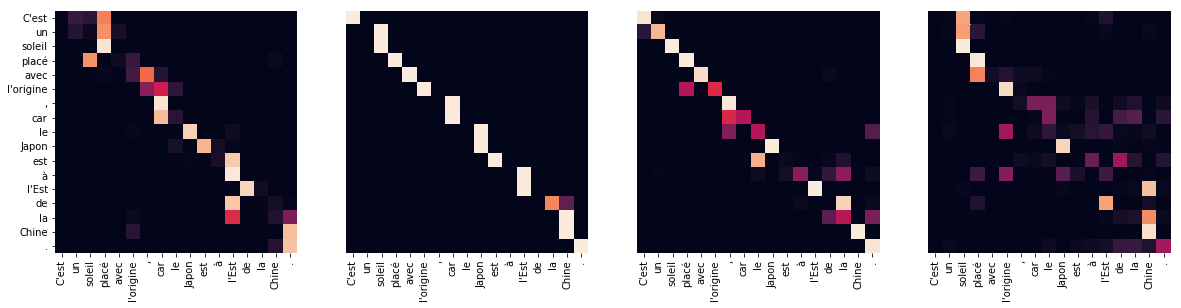

Encoder stack 2


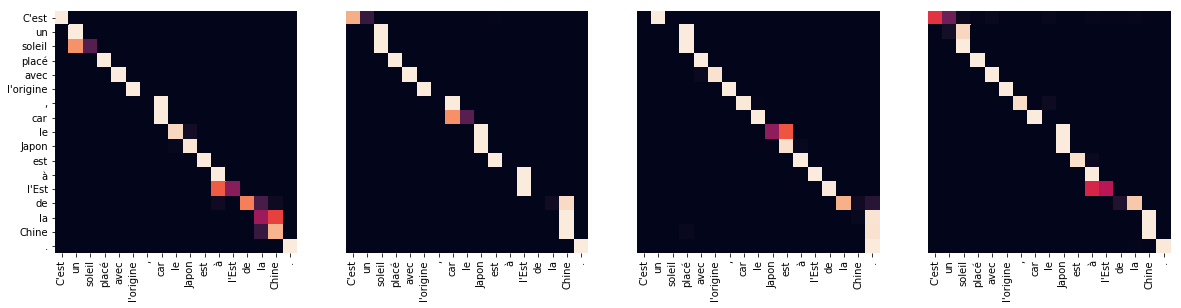

Encoder stack 3


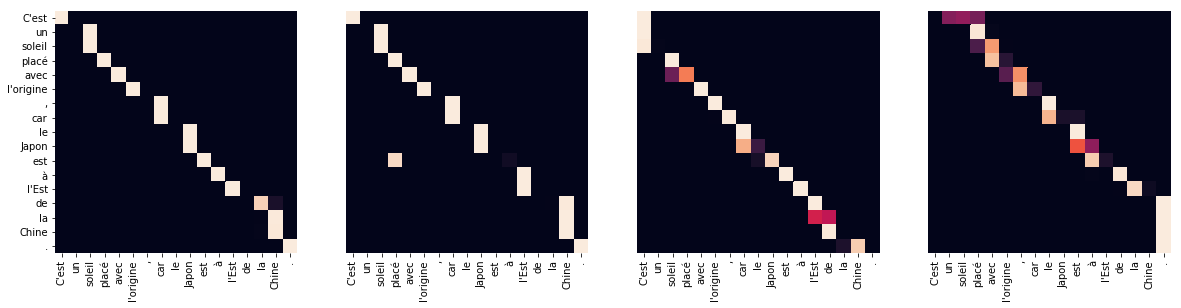

Encoder stack 4


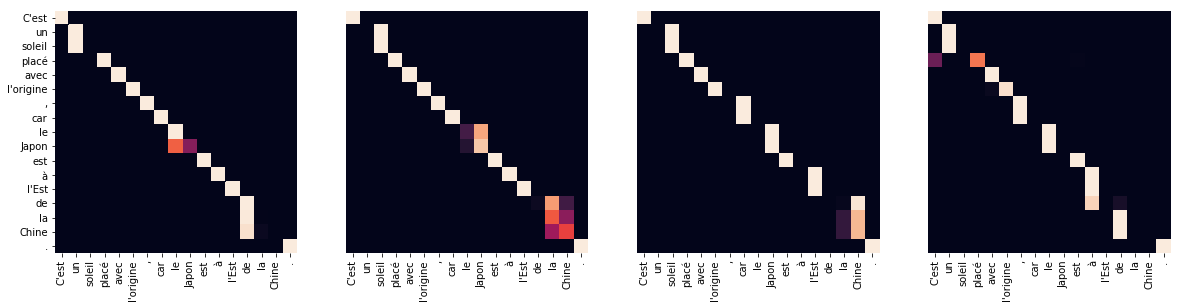

Encoder stack 5


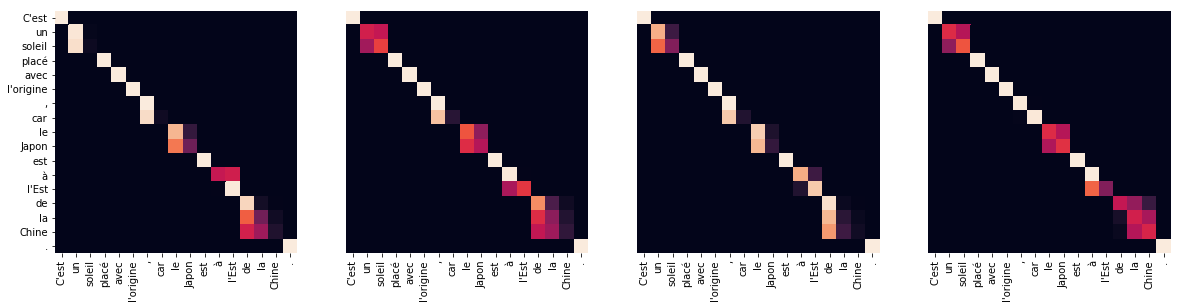

Encoder stack 6


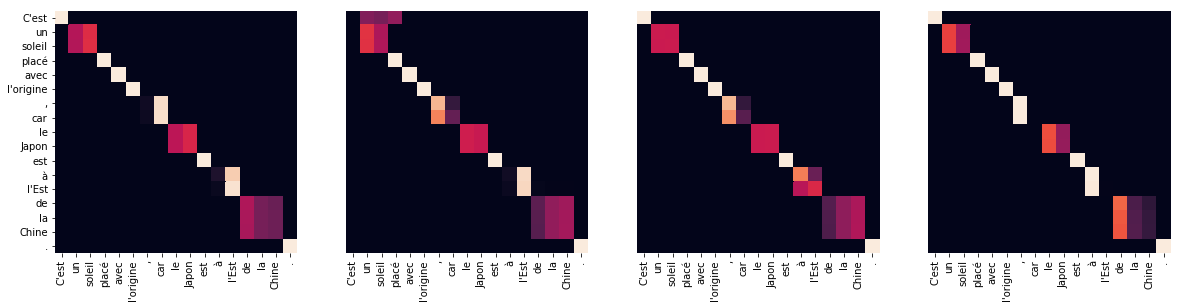

In [39]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Encoder stack", layer+1)
    for h in range(0, int(n_head/2)):
        draw(model.encoder.layers[layer].self_attention.attention.attention_weights[0, h, :sent_length, :sent_length].data, 
            sent[:sent_length], sent[:sent_length] if h ==0 else [], ax=axs[h])
    plt.show()

### Access the attention on decoder layer

In [40]:
model.decoder.layers[0].memory_attn.attention.attention_weights.shape

torch.Size([1, 8, 40, 38])

#### First 4 head on each stack
##### 4 first heads on each stack. Attention of source with respect to target

In [41]:
model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h].shape

torch.Size([40, 38])

Decoder stack 1


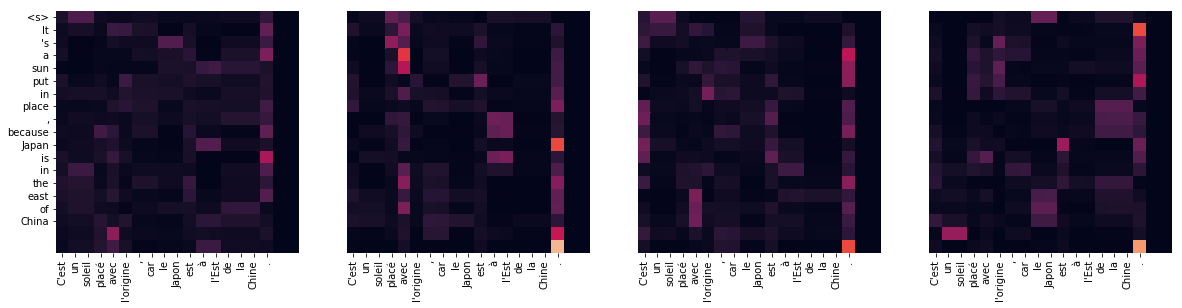

Decoder stack 2


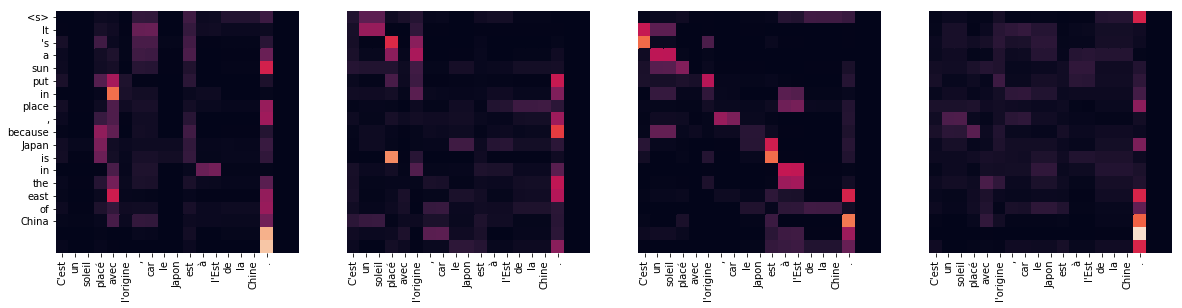

Decoder stack 3


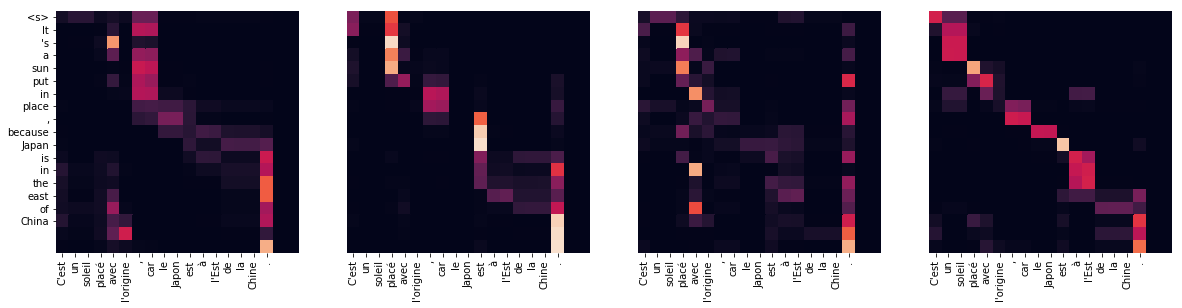

Decoder stack 4


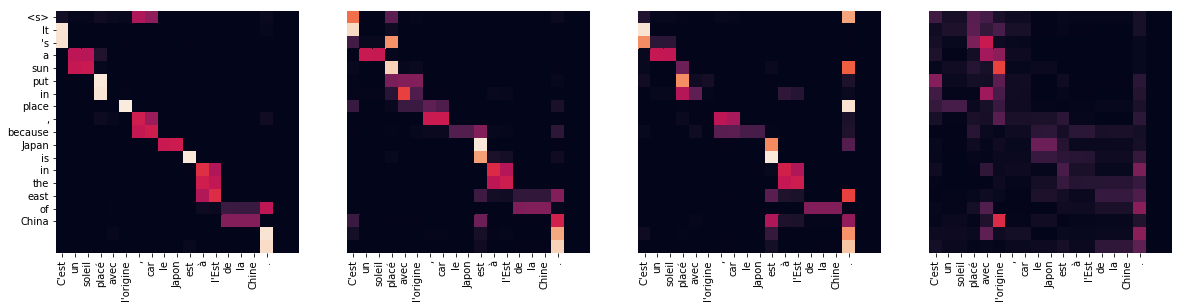

Decoder stack 5


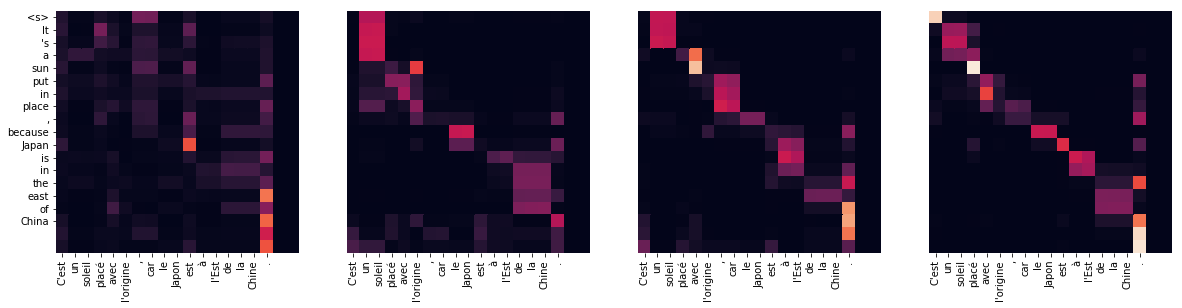

Decoder stack 6


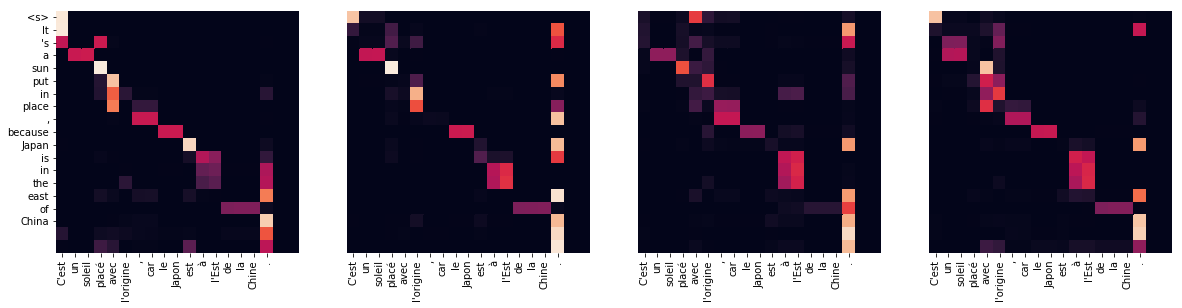

In [46]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Decoder stack", layer+1)
    for h in range(0, int(n_head/2)):
        draw(model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h, :trgt_lenght, :trgt_lenght].data, 
            x=sent[:sent_length], y=translation.split()[:sent_length] if h ==0 else [], ax=axs[h])
    plt.show()

#### First 4 head on each stack
##### 4 first heads on each stack. Attention of target with respect to target

In [43]:
model.decoder.layers[layer].self_attn.attention.attention_weights[0, h].shape

torch.Size([40, 40])

Decoder stack 1


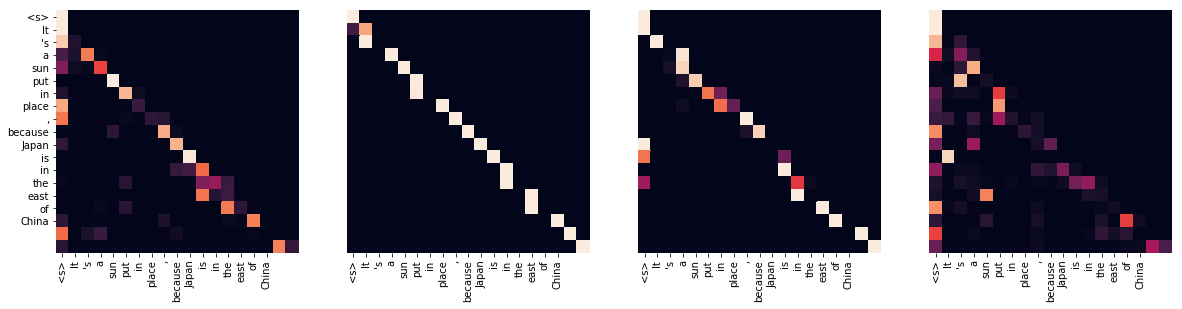

Decoder stack 2


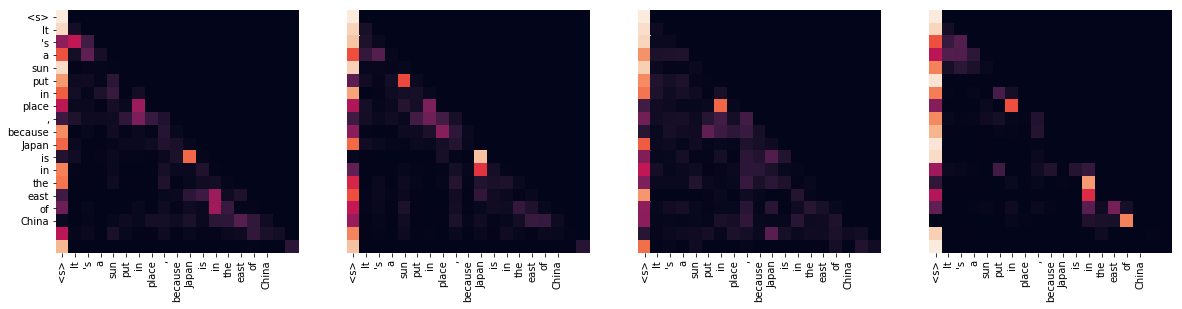

Decoder stack 3


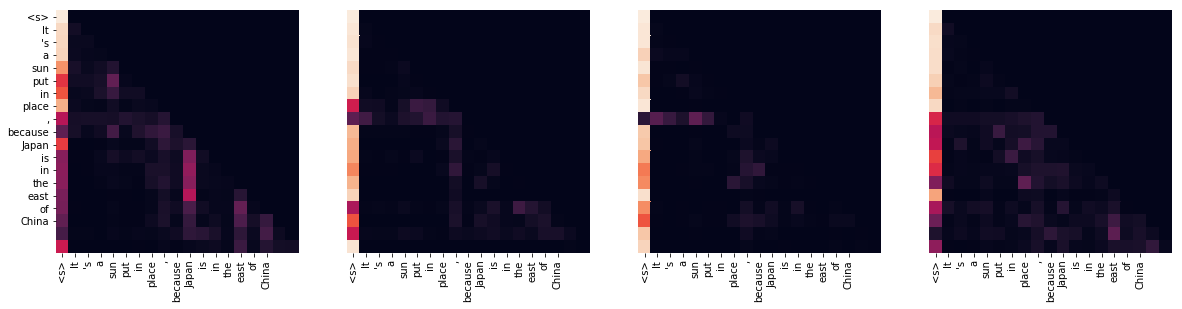

Decoder stack 4


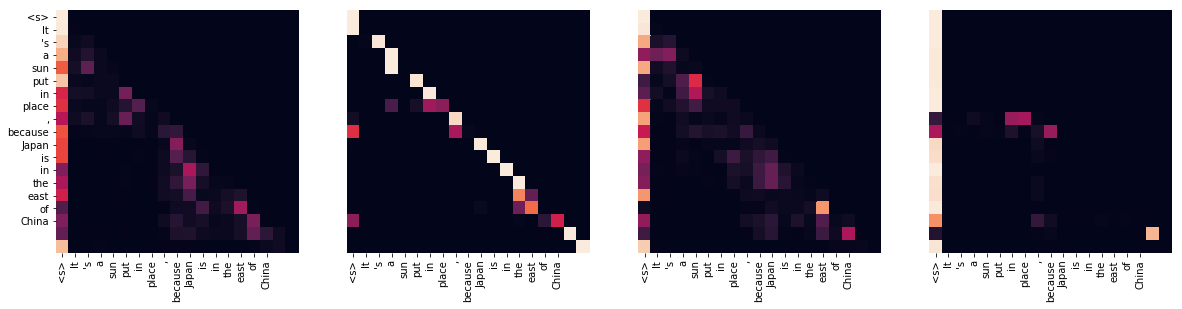

Decoder stack 5


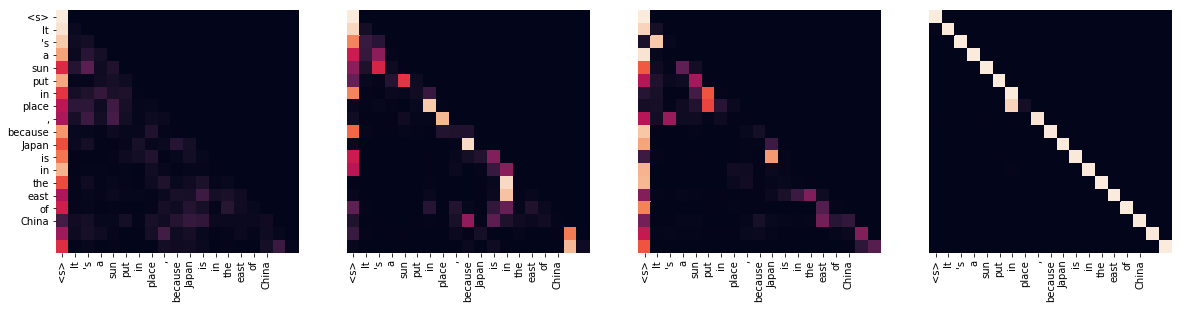

Decoder stack 6


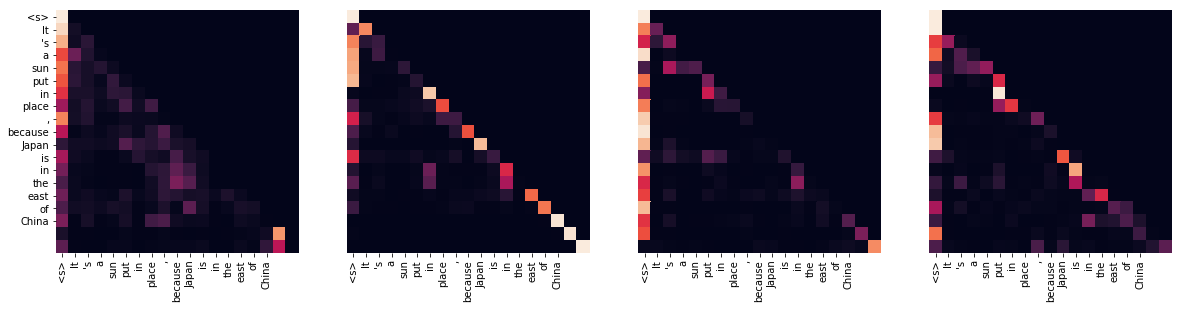

In [45]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Decoder stack", layer+1)
    for h in range(0, int(n_head/2)):
        draw(model.decoder.layers[layer].self_attn.attention.attention_weights[0, h, :trgt_lenght, :trgt_lenght].data, 
            x=translation.split()[:sent_length], y=translation.split()[:sent_length] if h ==0 else [], ax=axs[h])
    plt.show()

### Compare semantic and compute BLEU score

In [119]:
### Bleu score
from training.bleu_score import *
source_split = [word for word in source if word not in ['<blank>']]
target_split = [word for word in target if word not in ['<blank>']]
output_split = [word for word in translation.split() if word not in ['<blank>']]

In [120]:
chencherry = SmoothingFunction()
sentence_bleu([target_split], output_split, smoothing_function=chencherry.method0)

0.4682568791024402

In [121]:
# compare source, target and output
print(' '.join(source_split))
print(' '.join(target_split))
print(' '.join(output_split))

Si quelqu'un marche derrière , ça veut dire « suivre » .
<s> If someone walks behind , that is `` to follow . '' </s>
<s> If someone walks behind it , it means `` follow . '' </s>
